# Human eval

In [ ]:
from transformer_lens import HookedTransformer
from sae_lens import SAE, ActivationsStore, LanguageModelSAERunnerConfig
import torch
import os
from tqdm import tqdm
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(42)
torch.cuda.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

palette = sns.color_palette('flare', as_cmap=False, n_colors=10)
palette_duo = [palette[0], palette[-1]]

In [ ]:
cfg = LanguageModelSAERunnerConfig(
    # Data Generating Function (Model + Training Distibuion)
    model_name="pythia-160m-deduped",
    hook_name=None,
    hook_layer=None,
    dataset_path="NeelNanda/pile-small-tokenized-2b",
    is_dataset_tokenized=True,
    context_size=1024,
    streaming=True,
    # SAE Parameters
    architecture="jumprelu",
    d_in=768,
    d_sae=None,
    b_dec_init_method="zeros",
    expansion_factor=8,
    activation_fn="relu",  # relu, tanh-relu, topk
    normalize_sae_decoder=True,
    from_pretrained_path=None,
    apply_b_dec_to_input=False,
    # Activation Store Parameters
    n_batches_in_buffer=128,
    # Misc
    device=device,
    seed=42,
    dtype="float32",
    prepend_bos=False,
)

In [ ]:
model = HookedTransformer.from_pretrained("EleutherAI/pythia-160m-deduped", device = device)

direction = "backward"
ckpt_step = "500M"
sae_idx = 8
transfer = True

SAE_PATH = "/workspace/huggingface/hub/models--mech-interp--pythia-160m-deduped-rs-post/snapshots/49befceb8d1f7be1d4b3c6bef477c4e899def430"

#FWD_SAE_PATH = os.path.join(SAE_PATH, 'forward', f"L{sae_idx}", ckpt_step)
#BWD_SAE_PATH = os.path.join(SAE_PATH, 'backward', f"L{sae_idx}", ckpt_step)
#BASE_SAE_PATH = os.path.join(SAE_PATH, f"L{sae_idx}")

#fwd_sae = SAE.load_from_pretrained(FWD_SAE_PATH).to(device)
#bwd_sae = SAE.load_from_pretrained(BWD_SAE_PATH).to(device)
#base_sae = SAE.load_from_pretrained(BASE_SAE_PATH).to(device)

In [ ]:
activation_store = ActivationsStore.from_config(model, cfg)

## Histograms

In [ ]:
def list_flatten(nested_list):
    return [x for y in nested_list for x in y]

# A very handy function Neel wrote to get context around a feature activation
def make_token_df(tokens, len_prefix=5, len_suffix=3, model = model):
    str_tokens = [model.to_str_tokens(t) for t in tokens]
    unique_token = [[f"{s}/{i}" for i, s in enumerate(str_tok)] for str_tok in str_tokens]
    
    context = []
    prompt = []
    pos = []
    label = []
    for b in range(tokens.shape[0]):
        for p in range(tokens.shape[1]):
            prefix = "".join(str_tokens[b][max(0, p-len_prefix):p])
            if p==tokens.shape[1]-1:
                suffix = ""
            else:
                suffix = "".join(str_tokens[b][p+1:min(tokens.shape[1]-1, p+1+len_suffix)])
            current = str_tokens[b][p]
            context.append(f"{prefix}|{current}|{suffix}")
            prompt.append(b)
            pos.append(p)
            label.append(f"{b}/{p}")
    # print(len(batch), len(pos), len(context), len(label))
    return pd.DataFrame(dict(
        str_tokens=list_flatten(str_tokens),
        unique_token=list_flatten(unique_token),
        context=context,
        prompt=prompt,
        pos=pos,
        label=label,
    ))

In [ ]:
# finding max activating examples is a bit harder. To do this we need to calculate feature activations for a large number of tokens
feature_list = torch.randint(0, sae.cfg.d_sae, (32,))
examples_found = 0
all_fired_tokens = []
all_feature_acts = []
all_reconstructions = []
all_token_dfs = []

total_batches = 32
batch_size_prompts = activation_store.store_batch_size_prompts
batch_size_tokens = activation_store.context_size * batch_size_prompts
pbar = tqdm(range(total_batches))
for i in pbar:
    tokens = activation_store.get_batch_tokens()
    tokens_df = make_token_df(tokens)
    tokens_df["batch"] = i
    
    flat_tokens = tokens.flatten()
    
    with torch.no_grad():
        _, cache = model.run_with_cache(tokens, stop_at_layer = sae.cfg.hook_layer + 1, names_filter = [sae.cfg.hook_name])
        sae_in = cache[sae.cfg.hook_name]
        feature_acts = sae.encode(sae_in).squeeze()

        feature_acts = feature_acts.flatten(0,1)
        fired_mask = (feature_acts[:, feature_list]).sum(dim=-1) > 0
        fired_tokens = model.to_str_tokens(flat_tokens[fired_mask])
        reconstruction = feature_acts[fired_mask][:, feature_list] @ sae.W_dec[feature_list]

    token_df = tokens_df.iloc[fired_mask.cpu().nonzero().flatten().numpy()]
    all_token_dfs.append(token_df)
    all_feature_acts.append(feature_acts[fired_mask][:, feature_list])
    all_fired_tokens.append(fired_tokens)
    all_reconstructions.append(reconstruction)
    
    examples_found += len(fired_tokens)
    # print(f"Examples found: {examples_found}")
    # update description
    pbar.set_description(f"Examples found: {examples_found}")
    del cache
    
# flatten the list of lists
all_token_dfs = pd.concat(all_token_dfs).reset_index(drop=True)
all_fired_tokens = list_flatten(all_fired_tokens)
all_reconstructions = torch.cat(all_reconstructions)
all_feature_acts = torch.cat(all_feature_acts)

In [ ]:
# We need a filtering here on feature list...

In [ ]:
feature_acts_df = pd.DataFrame(all_feature_acts.detach().cpu().numpy(), columns = [f"feature_{i}" for i in feature_list])
feature_acts_df.shape
feature_idx = 1
# get non-zero activations

all_positive_acts = all_feature_acts[all_feature_acts[:, feature_idx] > 0][:, feature_idx].detach()
prop_positive_activations = 100*len(all_positive_acts) / (total_batches*batch_size_tokens)

px.histogram(
    all_positive_acts.cpu(),
    nbins=50,
    title=f"Histogram of positive activations of F{feature_list[feature_idx]} - {prop_positive_activations:.3f}% of activations were positive",
    labels={"value": "Activation"},
    width=800,)

In [ ]:
top_10_activations = feature_acts_df.sort_values(f"feature_{feature_list[feature_idx]}", ascending=False).head(10)
all_token_dfs.iloc[top_10_activations.index].join(feature_acts_df[f"feature_{feature_list[feature_idx]}"], how='left')

In [ ]:
print(f"Shape of the decoder weights {sae.W_dec.shape})")
print(f"Shape of the model unembed {model.W_U.shape}")
projection_matrix = sae.W_dec @ model.W_U
print(f"Shape of the projection matrix {projection_matrix.shape}")

# then we take the top_k tokens per feature and decode them
top_k = 10
# let's do this for 100 random features
_, top_k_tokens = torch.topk(projection_matrix[feature_list], top_k, dim=1)


feature_df = pd.DataFrame(top_k_tokens.cpu().numpy(), index = [f"feature_{i}" for i in feature_list]).T
feature_df.index = [f"token_{i}" for i in range(top_k)]
top_logits_df = feature_df.map(lambda x: model.tokenizer.decode(x))

In [ ]:
top_logits_df[f"feature_{feature_list[feature_idx]}"]

## Visualization

In [ ]:
from sae_vis.data_storing_fns import SaeVisData
from sae_vis.data_config_classes import SaeVisConfig

all_tokens = torch.cat([activation_store.get_batch_tokens() for _ in range(64)])

In [ ]:
ckpt_step = "500M"

features = torch.randint(0, model.cfg.d_model*8, (512,))

In [ ]:
for l in tqdm(range(12)):
    FWD_SAE_PATH = os.path.join(SAE_PATH, 'forward', f"L{l}", ckpt_step)
    BWD_SAE_PATH = os.path.join(SAE_PATH, 'backward', f"L{l}", ckpt_step)
    BASE_SAE_PATH = os.path.join(SAE_PATH, f"L{l}")

    print(f"Loading SAEs for layer {l} at {ckpt_step}")

    sae_vis_config = SaeVisConfig(
        hook_point = f"blocks.{l}.hook_resid_post",
        features = features,
        verbose = False,
    )

    try:
        fwd_sae = SAE.load_from_pretrained(FWD_SAE_PATH).to(device)
        fwd_vis_data = SaeVisData.create(
            encoder = fwd_sae,
            model = model,
            tokens = all_tokens,
            cfg = sae_vis_config,
        )
        fwd_vis_data.save_json(f"vis/l{l}_fwd.json")
    except Exception as e:
        print(f"Failed to load forward SAE for layer {l} - {e}")

    try:
        bwd_sae = SAE.load_from_pretrained(BWD_SAE_PATH).to(device)
        bwd_vis_data = SaeVisData.create(
            encoder = bwd_sae,
            model = model,
            tokens = all_tokens,
            cfg = sae_vis_config,
        )
        bwd_vis_data.save_json(f"vis/l{l}_bwd.json")
    except Exception as e:
        print(f"Failed to load backward SAE for layer {l} - {e}")

    try:
        base_sae = SAE.load_from_pretrained(BASE_SAE_PATH).to(device)
        base_vis_data = SaeVisData.create(
            encoder = base_sae,
            model = model,
            tokens = all_tokens,
            cfg = sae_vis_config,
        )
        base_vis_data.save_json(f"vis/l{l}_base.json")
    except Exception as e:
        print(f"Failed to load base SAE for layer {l} - {e}")

In [ ]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm

def count_shared_items(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    shared_items = set1.intersection(set2)
    return len(shared_items)

for l in tqdm(range(1, 11)):
    fwd_data = json.load(open(f"vis/l{l+1}_fwd.json", 'r'))['feature_data_dict']
    bwd_data = json.load(open(f"vis/l{l-1}_bwd.json", 'r'))['feature_data_dict']
    base_data = json.load(open(f"vis/l{l}_base.json", 'r'))['feature_data_dict']

    fwd_scores = {
        'feature': [],
        'top_logits': [],
        'bottom_logits': [],
        'max_toks': [],
    }

    bwd_scores = {
        'feature': [],
        'top_logits': [],
        'bottom_logits': [],
        'max_toks': [],
    }

    base_scores = {
        'feature': [],
        'top_logits': [],
        'bottom_logits': [],
        'max_toks': [],
    }

    for data, scores in tqdm(zip([fwd_data, bwd_data, base_data], [fwd_scores, bwd_scores, base_scores])):
        for f, f_data in data.items():
            logit_data = f_data['logits_table_data']
            top_logits = logit_data['top_token_ids']
            bottom_logits = logit_data['bottom_token_ids']

            token_data = f_data['sequence_data']['seq_group_data'][0]['seq_data']
            max_toks = []

            for seq in token_data[:10]:
                tok_ids, f_acts, loss_contrib = seq['token_ids'], seq['feat_acts'], seq['loss_contribution']
                assert len(tok_ids) == len(f_acts) == len(loss_contrib)
                max_tok = tok_ids[np.argmax(np.array(f_acts) + np.array(loss_contrib))]
                max_toks.append(max_tok)

            scores['feature'].append(f)
            scores['top_logits'].append(top_logits)
            scores['bottom_logits'].append(bottom_logits)
            scores['max_toks'].append(max_toks)

    fwd_df = pd.DataFrame(fwd_scores)
    bwd_df = pd.DataFrame(bwd_scores)
    base_df = pd.DataFrame(base_scores)

    fwd_df = fwd_df.add_suffix('_fwd')
    bwd_df = bwd_df.add_suffix('_bwd')
    base_df = base_df.add_suffix('_base')

    total_df = pd.concat([fwd_df, bwd_df, base_df], axis=1)

    total_df['shared_fwd_top_logits'] = total_df.apply(lambda x: count_shared_items(x['top_logits_fwd'], x['top_logits_base']), axis=1)
    total_df['shared_fwd_bottom_logits'] = total_df.apply(lambda x: count_shared_items(x['bottom_logits_fwd'], x['bottom_logits_base']), axis=1)
    total_df['shared_fwd_max_toks'] = total_df.apply(lambda x: count_shared_items(x['max_toks_fwd'], x['max_toks_base']), axis=1)

    total_df['shared_bwd_top_logits'] = total_df.apply(lambda x: count_shared_items(x['top_logits_bwd'], x['top_logits_base']), axis=1)
    total_df['shared_bwd_bottom_logits'] = total_df.apply(lambda x: count_shared_items(x['bottom_logits_bwd'], x['bottom_logits_base']), axis=1)
    total_df['shared_bwd_max_toks'] = total_df.apply(lambda x: count_shared_items(x['max_toks_bwd'], x['max_toks_base']), axis=1)

    result_df = total_df[['feature_base', 'shared_fwd_top_logits', 'shared_fwd_bottom_logits', 'shared_fwd_max_toks', 'shared_bwd_top_logits', 'shared_bwd_bottom_logits', 'shared_bwd_max_toks']]
    result_df.to_csv(f"vis/l{l}_result.csv", index=False)

In [30]:
threshold = 4

all_results_df = []

for l in range(1, 11):
    result_df = pd.read_csv(f"vis/l{l}_result.csv")
    result_df.iloc[:, 1:] = result_df.iloc[:, 1:].map(lambda x: 1 if x >= threshold else 0)
    result_df['layer'] = l
    
    all_results_df.append(result_df)

all_results_df = pd.concat(all_results_df)

In [31]:
all_results_df

,feature_base,shared_fwd_top_logits,shared_fwd_bottom_logits,shared_fwd_max_toks,shared_bwd_top_logits,shared_bwd_bottom_logits,shared_bwd_max_toks,layer
0,3174,1,0,0,0,0,0,1
1,5555,0,0,0,1,1,0,1
2,2908,0,0,0,0,0,0,1
3,1294,0,0,0,0,0,0,1
4,5226,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
483,1346,1,1,0,1,1,1,10
484,127,1,0,0,0,0,0,10
485,17,1,0,0,0,0,0,10
486,1816,1,0,0,1,0,0,10


In [36]:
all_results_df['bwd_feature_transfer'] = (all_results_df['shared_bwd_top_logits'] + all_results_df['shared_bwd_bottom_logits'] + all_results_df['shared_bwd_max_toks']) > 1
all_results_df['fwd_feature_transfer'] = (all_results_df['shared_fwd_top_logits'] + all_results_df['shared_fwd_bottom_logits'] + all_results_df['shared_fwd_max_toks']) > 1

In [35]:
plot_df.groupby(['layer', 'Transfer']).mean()

Transferability
layer Transfer                             
1     bwd_feature_transfer              0.0
      fwd_feature_transfer              0.0
2     bwd_feature_transfer              0.0
      fwd_feature_transfer              0.0
3     bwd_feature_transfer              0.0
      fwd_feature_transfer              0.0
4     bwd_feature_transfer              0.0
      fwd_feature_transfer              0.0
5     bwd_feature_transfer              0.0
      fwd_feature_transfer              0.0
6     bwd_feature_transfer              0.0
      fwd_feature_transfer              0.0
7     bwd_feature_transfer              0.0
      fwd_feature_transfer              0.0
8     bwd_feature_transfer              0.0
      fwd_feature_transfer              0.0
9     bwd_feature_transfer              0.0
      fwd_feature_transfer              0.0
10    bwd_feature_transfer              0.0
      fwd_feature_transfer              0.0

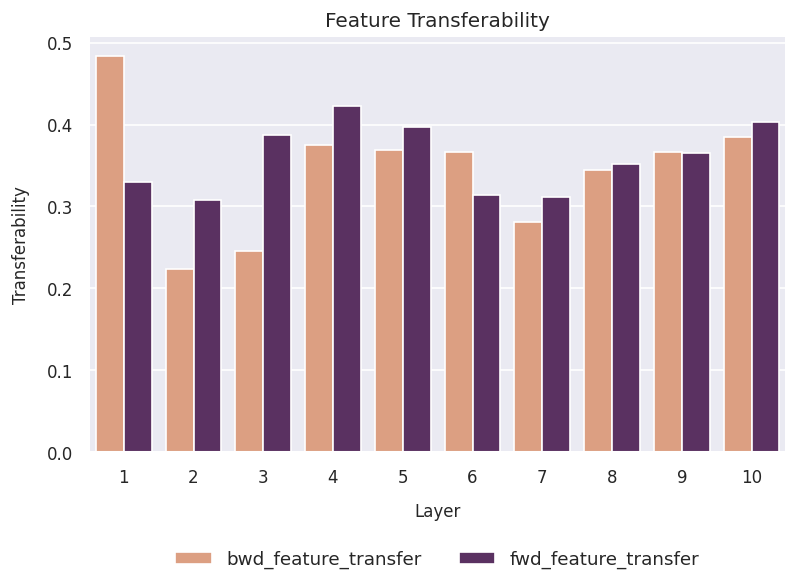

In [39]:
plot_df = all_results_df[['layer', 'fwd_feature_transfer', 'bwd_feature_transfer']].melt(id_vars='layer', var_name='Transfer', value_name='Transferability')

plt.figure(figsize=(7.5, 4.5), dpi=120)
sns.set_theme()
ax = sns.barplot(
    data=plot_df.groupby(['layer', 'Transfer']).mean(),
    x='layer',
    y='Transferability',
    hue='Transfer',
    palette=palette_duo,
)

ax.title.set_fontsize(13)
ax.xaxis.label.set_fontsize(10)
ax.yaxis.label.set_fontsize(10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10

# Set title and move legend out of the plot
plt.title("Feature Transferability")
plt.xlabel("Layer")
plt.legend()
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, -0.32), ncol=3, title=None, frameon=False)
plt.savefig("img/f_transfer.png", bbox_inches='tight', dpi=300)
plt.show()

## Feature attribution

In [ ]:
from dataclasses import dataclass
from functools import partial
from typing import Any, Literal, NamedTuple, Callable

import torch
from sae_lens import SAE
from transformer_lens import HookedTransformer
from transformer_lens.hook_points import HookPoint


class SaeReconstructionCache(NamedTuple):
    sae_in: torch.Tensor
    feature_acts: torch.Tensor
    sae_out: torch.Tensor
    sae_error: torch.Tensor


def track_grad(tensor: torch.Tensor) -> None:
    """wrapper around requires_grad and retain_grad"""
    tensor.requires_grad_(True)
    tensor.retain_grad()


@dataclass
class ApplySaesAndRunOutput:
    model_output: torch.Tensor
    model_activations: dict[str, torch.Tensor]
    sae_activations: dict[str, SaeReconstructionCache]

    def zero_grad(self) -> None:
        """Helper to zero grad all tensors in this object."""
        self.model_output.grad = None
        for act in self.model_activations.values():
            act.grad = None
        for cache in self.sae_activations.values():
            cache.sae_in.grad = None
            cache.feature_acts.grad = None
            cache.sae_out.grad = None
            cache.sae_error.grad = None


def apply_saes_and_run(
    model: HookedTransformer,
    saes: dict[str, SAE],
    input: Any,
    include_error_term: bool = True,
    track_model_hooks: list[str] | None = None,
    return_type: Literal["logits", "loss"] = "logits",
    track_grads: bool = False,
) -> ApplySaesAndRunOutput:
    """
    Apply the SAEs to the model at the specific hook points, and run the model.
    By default, this will include a SAE error term which guarantees that the SAE
    will not affect model output. This function is designed to work correctly with
    backprop as well, so it can be used for gradient-based feature attribution.

    Args:
        model: the model to run
        saes: the SAEs to apply
        input: the input to the model
        include_error_term: whether to include the SAE error term to ensure the SAE doesn't affect model output. Default True
        track_model_hooks: a list of hook points to record the activations and gradients. Default None
        return_type: this is passed to the model.run_with_hooks function. Default "logits"
        track_grads: whether to track gradients. Default False
    """

    fwd_hooks = []
    bwd_hooks = []

    sae_activations: dict[str, SaeReconstructionCache] = {}
    model_activations: dict[str, torch.Tensor] = {}

    # this hook just track the SAE input, output, features, and error. If `track_grads=True`, it also ensures
    # that requires_grad is set to True and retain_grad is called for intermediate values.
    def reconstruction_hook(sae_in: torch.Tensor, hook: HookPoint, hook_point: str):  # noqa: ARG001
        sae = saes[hook_point]
        feature_acts = sae.encode(sae_in)
        sae_out = sae.decode(feature_acts)
        sae_error = (sae_in - sae_out).detach().clone()
        if track_grads:
            track_grad(sae_error)
            track_grad(sae_out)
            track_grad(feature_acts)
            track_grad(sae_in)
        sae_activations[hook_point] = SaeReconstructionCache(
            sae_in=sae_in,
            feature_acts=feature_acts,
            sae_out=sae_out,
            sae_error=sae_error,
        )

        if include_error_term:
            return sae_out + sae_error
        return sae_out

    def sae_bwd_hook(output_grads: torch.Tensor, hook: HookPoint):  # noqa: ARG001
        # this just passes the output grads to the input, so the SAE gets the same grads despite the error term hackery
        return (output_grads,)

    # this hook just records model activations, and ensures that intermediate activations have gradient tracking turned on if needed
    def tracking_hook(hook_input: torch.Tensor, hook: HookPoint, hook_point: str):  # noqa: ARG001
        model_activations[hook_point] = hook_input
        if track_grads:
            track_grad(hook_input)
        return hook_input

    for hook_point in saes.keys():
        fwd_hooks.append(
            (hook_point, partial(reconstruction_hook, hook_point=hook_point))
        )
        bwd_hooks.append((hook_point, sae_bwd_hook))
    for hook_point in track_model_hooks or []:
        fwd_hooks.append((hook_point, partial(tracking_hook, hook_point=hook_point)))

    # now, just run the model while applying the hooks
    with model.hooks(fwd_hooks=fwd_hooks, bwd_hooks=bwd_hooks):
        model_output = model(input, return_type=return_type)

    return ApplySaesAndRunOutput(
        model_output=model_output,
        model_activations=model_activations,
        sae_activations=sae_activations,
    )

In [ ]:
from dataclasses import dataclass
from transformer_lens.hook_points import HookPoint
from dataclasses import dataclass
from functools import partial
from typing import Any, Literal, NamedTuple

import torch
from sae_lens import SAE
from transformer_lens import HookedTransformer
from sae_lens import HookedSAETransformer
from transformer_lens.hook_points import HookPoint

EPS = 1e-8

torch.set_grad_enabled(True)
@dataclass
class AttributionGrads:
    metric: torch.Tensor
    model_output: torch.Tensor
    model_activations: dict[str, torch.Tensor]
    sae_activations: dict[str, SaeReconstructionCache]


@dataclass
class Attribution:
    model_attributions: dict[str, torch.Tensor]
    model_activations: dict[str, torch.Tensor]
    model_grads: dict[str, torch.Tensor]
    sae_feature_attributions: dict[str, torch.Tensor]
    sae_feature_activations: dict[str, torch.Tensor]
    sae_feature_grads: dict[str, torch.Tensor]
    sae_errors_attribution_proportion: dict[str, float]


def calculate_attribution_grads(
    model: HookedSAETransformer,
    prompt: str,
    metric_fn: Callable[[torch.Tensor], torch.Tensor],
    track_hook_points: list[str] | None = None,
    include_saes: dict[str, SAE] | None = None,
    return_logits: bool = True,
    include_error_term: bool = True,
) -> AttributionGrads:
    """
    Wrapper around apply_saes_and_run that calculates gradients wrt to the metric_fn.
    Tracks grads for both SAE feature and model neurons, and returns them in a structured format.
    """
    output = apply_saes_and_run(
        model,
        saes=include_saes or {},
        input=prompt,
        return_type="logits" if return_logits else "loss",
        track_model_hooks=track_hook_points,
        include_error_term=include_error_term,
        track_grads=True,
    )
    metric = metric_fn(output.model_output)
    output.zero_grad()
    metric.backward()
    return AttributionGrads(
        metric=metric,
        model_output=output.model_output,
        model_activations=output.model_activations,
        sae_activations=output.sae_activations,
    )


def calculate_feature_attribution(
    model: HookedSAETransformer,
    input: Any,
    metric_fn: Callable[[torch.Tensor], torch.Tensor],
    track_hook_points: list[str] | None = None,
    include_saes: dict[str, SAE] | None = None,
    return_logits: bool = True,
    include_error_term: bool = True,
) -> Attribution:
    """
    Calculate feature attribution for SAE features and model neurons following
    the procedure in https://transformer-circuits.pub/2024/march-update/index.html#feature-heads.
    This include the SAE error term by default, so inserting the SAE into the calculation is
    guaranteed to not affect the model output. This can be disabled by setting `include_error_term=False`.

    Args:
        model: The model to calculate feature attribution for.
        input: The input to the model.
        metric_fn: A function that takes the model output and returns a scalar metric.
        track_hook_points: A list of model hook points to track activations for, if desired
        include_saes: A dictionary of SAEs to include in the calculation. The key is the hook point to apply the SAE to.
        return_logits: Whether to return the model logits or loss. This is passed to TLens, so should match whatever the metric_fn expects (probably logits)
        include_error_term: Whether to include the SAE error term in the calculation. This is recommended, as it ensures that the SAE will not affecting the model output.
    """
    # first, calculate gradients wrt to the metric_fn.
    # these will be multiplied with the activation values to get the attributions
    outputs_with_grads = calculate_attribution_grads(
        model,
        input,
        metric_fn,
        track_hook_points,
        include_saes=include_saes,
        return_logits=return_logits,
        include_error_term=include_error_term,
    )
    model_attributions = {}
    model_activations = {}
    model_grads = {}
    sae_feature_attributions = {}
    sae_feature_activations = {}
    sae_feature_grads = {}
    sae_error_proportions = {}
    # this code is long, but all it's doing is multiplying the grads by the activations
    # and recording grads, acts, and attributions in dictionaries to return to the user
    with torch.no_grad():
        for name, act in outputs_with_grads.model_activations.items():
            assert act.grad is not None
            raw_activation = act.detach().clone()
            model_attributions[name] = (act.grad * raw_activation).detach().clone()
            model_activations[name] = raw_activation
            model_grads[name] = act.grad.detach().clone()
        for name, act in outputs_with_grads.sae_activations.items():
            assert act.feature_acts.grad is not None
            assert act.sae_out.grad is not None
            raw_activation = act.feature_acts.detach().clone()
            sae_feature_attributions[name] = (
                (act.feature_acts.grad * raw_activation).detach().clone()
            )
            sae_feature_activations[name] = raw_activation
            sae_feature_grads[name] = act.feature_acts.grad.detach().clone()
            if include_error_term:
                assert act.sae_error.grad is not None
                error_grad_norm = act.sae_error.grad.norm().item()
            else:
                error_grad_norm = 0
            sae_out_norm = act.sae_out.grad.norm().item()
            sae_error_proportions[name] = error_grad_norm / (
                sae_out_norm + error_grad_norm + EPS
            )
        return Attribution(
            model_attributions=model_attributions,
            model_activations=model_activations,
            model_grads=model_grads,
            sae_feature_attributions=sae_feature_attributions,
            sae_feature_activations=sae_feature_activations,
            sae_feature_grads=sae_feature_grads,
            sae_errors_attribution_proportion=sae_error_proportions,
        )

In [ ]:
attr_df = pd.read_csv("eval/test_attr.csv")

def check_single_token(x):
    try:
        model.to_single_token(" " + x)
        return True
    except:
        return False

attr_df['Correct Single Token'] = attr_df['Correct Answer'].apply(check_single_token)
attr_df['Wrong Single Token'] = attr_df['Wrong Answer'].apply(check_single_token)

attr_df = attr_df[(attr_df['Correct Single Token']) & (attr_df['Wrong Single Token'])].iloc[:, :-2].drop_duplicates()
attr_df.head()

In [ ]:
def get_prompt(idx):
    row = attr_df.iloc[idx]
    prompt = row['Sentence']
    
    pos_token = model.tokenizer.encode(" " + row['Correct Answer'], add_special_tokens=False)
    neg_token = model.tokenizer.encode(" " + row['Wrong Answer'], add_special_tokens=False)

    return prompt, pos_token, neg_token

In [ ]:
def convert_sparse_feature_to_long_df(sparse_tensor: torch.Tensor) -> pd.DataFrame:
    """
    Convert a sparse tensor to a long format pandas DataFrame.
    """
    df = pd.DataFrame(sparse_tensor.detach().cpu().numpy())
    df_long = df.melt(ignore_index=False, var_name='column', value_name='value')
    df_long.columns = ["feature", "attribution"]
    df_long_nonzero = df_long[df_long['attribution'] != 0]
    df_long_nonzero = df_long_nonzero.reset_index().rename(columns={'index': 'position'})
    return df_long_nonzero

In [ ]:
ckpt_step = "100M"

base_fa_scores = []
fwd_fa_scores = []
bwd_fa_scores = []

for l in tqdm(range(1,11)):
    
    FWD_SAE_PATH = os.path.join(SAE_PATH, 'forward', f"L{l}", ckpt_step)
    BWD_SAE_PATH = os.path.join(SAE_PATH, 'backward', f"L{l}", ckpt_step)
    BASE_SAE_PATH = os.path.join(SAE_PATH, f"L{l}")

    fwd_sae = SAE.load_from_pretrained(FWD_SAE_PATH).to(device)
    bwd_sae = SAE.load_from_pretrained(BWD_SAE_PATH).to(device)
    base_sae = SAE.load_from_pretrained(BASE_SAE_PATH).to(device)
    
    for i in range(attr_df.shape[0]):
        prompt, pos_token, neg_token = get_prompt(i)
        
        def metric_fn(logits: torch.tensor, pos_token: torch.tensor =pos_token, neg_token: torch.Tensor=neg_token) -> torch.Tensor:
            return logits[0,-1,pos_token] - logits[0,-1,neg_token]

        base_fa = calculate_feature_attribution(
            input = prompt,
            model = model,
            metric_fn = metric_fn,
            include_saes={base_sae.cfg.hook_name: base_sae},
            include_error_term=True,
            return_logits=True,
        )

        #fwd_fa = calculate_feature_attribution(
        #    input = prompt,
        #    model = model,
        #    metric_fn = metric_fn,
        #    include_saes={fwd_sae.cfg.hook_name: fwd_sae},
        #    include_error_term=True,
        #    return_logits=True,
        #)

        #bwd_fa = calculate_feature_attribution(
        #    input = prompt,
        #    model = model,
        #    metric_fn = metric_fn,
        #    include_saes={bwd_sae.cfg.hook_name: bwd_sae},
        #    include_error_term=True,
        #    return_logits=True,
        #)

        base_fa_df = convert_sparse_feature_to_long_df(base_fa.sae_feature_attributions[base_sae.cfg.hook_name][0])
        #fwd_fa_df = convert_sparse_feature_to_long_df(fwd_fa.sae_feature_attributions[fwd_sae.cfg.hook_name][0])
        #bwd_fa_df = convert_sparse_feature_to_long_df(bwd_fa.sae_feature_attributions[bwd_sae.cfg.hook_name][0])

        base_fa_scores.append(base_fa_df['attribution'].max())
        #fwd_fa_scores.append(fwd_fa_df['attribution'].max())
        #bwd_fa_scores.append(bwd_fa_df['attribution'].max())

In [ ]:
import numpy as np 

scores_df = pd.DataFrame(
    {
        "Layer": np.arange(1,11)[:, None].repeat(len(attr_df)),
        "No transfer": base_fa_scores,
        #"Forward": fwd_fa_scores,
        #"Backward": bwd_fa_scores,
    }
)

scores_df = scores_df.melt(id_vars='Layer', var_name='Transfer', value_name='Max Attribution Score')
#scores_df.to_csv(f"eval/dla_scores_base.csv", index=False)
avg_scores_df = scores_df.groupby(['Layer', 'Transfer']).mean().reset_index()

In [ ]:
dla_scores_base = pd.read_csv("eval/dla_scores_base.csv")
dla_scores_100 = pd.read_csv("eval/dla_scores_100M.csv")
dla_scores_200 = pd.read_csv("eval/dla_scores_200M.csv")
dla_scores_300 = pd.read_csv("eval/dla_scores_300M.csv")
dla_scores_400 = pd.read_csv("eval/dla_scores_400M.csv")
dla_scores_500 = pd.read_csv("eval/dla_scores_500M.csv")

dla_scores_100['Checkpoint'] = '100M'
dla_scores_200['Checkpoint'] = '200M'
dla_scores_300['Checkpoint'] = '300M'
dla_scores_400['Checkpoint'] = '400M'
dla_scores_500['Checkpoint'] = '500M'

dla_scores = pd.concat([dla_scores_100, dla_scores_200, dla_scores_300, dla_scores_400, dla_scores_500])
dla_scores = dla_scores[dla_scores['Transfer'] != 'No transfer']
avg_scores_df = dla_scores.groupby(['Transfer', 'Checkpoint']).mean().reset_index()
avg_base_scores = dla_scores_base.groupby(['Transfer']).mean().reset_index()

In [ ]:
plt.figure(figsize=(6, 4), dpi=120)
sns.set_theme()
ax0 = sns.lineplot(
    avg_scores_df,
    x="Checkpoint",
    y="Max Attribution Score",
    hue="Transfer",
    marker='o',
    markersize=6,
    palette=palette_duo,
    hue_order=['Forward', 'Backward']
)

plt.hlines(avg_base_scores['Max Attribution Score'], 0, 4, linestyles='dashed', label='No transfer', color='grey')


ax0.title.set_fontsize(13)
ax0.xaxis.label.set_fontsize(10)
ax0.yaxis.label.set_fontsize(10)
ax0.tick_params(axis='both', which='major', labelsize=10)
ax0.xaxis.labelpad = 10
ax0.yaxis.labelpad = 10

# Set plot title and labels
plt.title("Direct Logit Attribution Scores")
plt.ylabel("Avg. Attribution Score")
# add baseline to legend
plt.legend()
sns.move_legend(ax0, "lower center", bbox_to_anchor=(.5, -0.35), ncol=3, title=None, frameon=False)
plt.savefig("img/dla_scores.png", bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
fwd_dla_scores = dla_scores[dla_scores['Transfer'] == 'Forward'].drop(columns=['Transfer'])
bwd_dla_scores = dla_scores[dla_scores['Transfer'] == 'Backward'].drop(columns=['Transfer'])

avg_fwd_scores = fwd_dla_scores.groupby(['Checkpoint', 'Layer']).mean().reset_index()
avg_bwd_scores = bwd_dla_scores.groupby(['Checkpoint', 'Layer']).mean().reset_index()
avg_base_scores = dla_scores_base.groupby(['Transfer', 'Layer']).mean().reset_index()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10.5, 4.5), dpi=120)
sns.set_theme()
ax0 = sns.lineplot(
    avg_fwd_scores,
    x="Checkpoint",
    y="Max Attribution Score",
    hue="Layer",
    ax=ax[0],
    legend=False,
    marker='o',
    markersize=6,
    palette=palette,
)

ax1 = sns.lineplot(
    avg_bwd_scores,
    x="Checkpoint",
    y="Max Attribution Score",
    hue="Layer",
    ax=ax[1],
    legend='full',
    marker='o',
    markersize=6,
    palette=palette
)

# Set plot title and labels
ax[0].set_title("Forward Feature Attribution Scores")
ax[0].set_ylabel("Attribution Score")
ax[0].set_xlabel("Checkpoint")

ax[1].set_title("Backward Feature Attribution Scores")
ax[1].set_ylabel("Attribution Score")
ax[1].set_xlabel("Checkpoint")

for a in ax:
    a.title.set_fontsize(13)
    a.xaxis.label.set_fontsize(10)
    a.yaxis.label.set_fontsize(10)
    a.tick_params(axis='both', which='major', labelsize=10)
    a.xaxis.labelpad = 10
    a.yaxis.labelpad = 10

# Adjust legend placement
ax[1].legend(title="Layer", bbox_to_anchor=(1.02, 1), loc='upper left')

# Apply tight layout to adjust all elements
plt.tight_layout()
sns.move_legend(ax1, "lower center", bbox_to_anchor=(-0.13, -0.35), ncol=5, title=None, frameon=False)
plt.savefig("img/dla_indv_scores.png", bbox_inches='tight', dpi=300)

plt.show()

### Similarities

In [ ]:
ckpt_step = "500M"

base_fwd_similarities = []
base_bwd_similarities = []

for i in tqdm(range(1, 11)):
    BASE_SAE_PATH = os.path.join(SAE_PATH, f"L{i}", ckpt_step)
    base_sae = SAE.load_from_pretrained(BASE_SAE_PATH).to(device)

    base_W_dec = base_sae.W_dec

    FWD_SAE_PATH = os.path.join(SAE_PATH, 'forward', f"L{i}", ckpt_step)
    BWD_SAE_PATH = os.path.join(SAE_PATH, 'backward', f"L{i}", ckpt_step)
    
    fwd_sae = SAE.load_from_pretrained(FWD_SAE_PATH).to(device)
    bwd_sae = SAE.load_from_pretrained(BWD_SAE_PATH).to(device)
    
    fwd_W_dec = fwd_sae.W_dec
    bwd_W_dec = bwd_sae.W_dec

    base_fwd_sim = (fwd_W_dec @ base_W_dec.T).max(-1).values.mean()
    base_bwd_sim = (bwd_W_dec @ base_W_dec.T).max(-1).values.mean()

    base_fwd_similarities.append(base_fwd_sim.item())
    base_bwd_similarities.append(base_bwd_sim.item())

In [ ]:
import numpy as np

fig = plt.figure(figsize=(6, 4), dpi=120)
sns.set_theme()
ax0 = sns.lineplot(
    x=np.arange(1, 11),
    y=base_fwd_similarities,
    marker='o',
    markersize=6,
    color=palette[0],
)

ax1 = sns.lineplot(
    x=np.arange(1, 11),
    y=base_bwd_similarities,
    legend=False,
    marker='o',
    markersize=6,
    color=palette[-1],
)

ax0.title.set_fontsize(13)
ax0.xaxis.label.set_fontsize(10)
ax0.yaxis.label.set_fontsize(10)
ax0.tick_params(axis='both', which='major', labelsize=10)
ax0.xaxis.labelpad = 10
ax0.yaxis.labelpad = 10

# Set plot title and labels
plt.title("MMCS between Transfer and No transfer SAEs")
plt.ylabel("MMCS")
plt.xlabel("Layer")
plt.legend(title="Transfer", labels=["Forward", "_", "Backward", "_"], bbox_to_anchor=(1.03, 1), loc='upper left')
plt.ylim(0.59, 0.91)
sns.move_legend(ax0, "lower center", bbox_to_anchor=(.5, -0.35), ncol=3, title=None, frameon=False)
plt.savefig("img/mmcs_scores.png", bbox_inches='tight', dpi=300)
plt.show()

## Human Interpretability

In [ ]:
hi_df = pd.read_csv("eval/human_interp.csv").fillna("y").drop("Feature", axis=1)
hi_df = hi_df.melt(id_vars='Layer', var_name='Transfer', value_name='Human Interpretability Score')
hi_df['Human Interpretability Score'] = hi_df['Human Interpretability Score'].apply(lambda x: 0 if x == "n" else 1)

In [ ]:
fwd_mask = (hi_df['Layer'] == 0) & (hi_df['Transfer'] == 'Forward')
bwd_mask = (hi_df['Layer'] == 11) & (hi_df['Transfer'] == 'Backward')

hi_df.loc[fwd_mask, 'Human Interpretability Score'] = 0
hi_df.loc[bwd_mask, 'Human Interpretability Score'] = 0

In [ ]:
plt.figure(figsize=(7.5, 4.5), dpi=120)
sns.set_theme()
ax = sns.barplot(
    hi_df,
    x="Layer",
    y="Human Interpretability Score",
    hue="Transfer",
    orient="v",
    hue_order=["Forward", "Backward", "No transfer"],
    palette=palette_duo + ['darkgrey'],
)

ax.title.set_fontsize(13)
ax.xaxis.label.set_fontsize(10)
ax.yaxis.label.set_fontsize(10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10

# Set title and move legend out of the plot
plt.title("Human Interpretability Scores")
plt.legend()
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, -0.32), ncol=3, title=None, frameon=False)
plt.savefig("img/hi_scores.png", bbox_inches='tight', dpi=300)
plt.show()